# CAPEv2 Dataset Exploration

This notebook helps us understand the structure and contents of the AVAST-CTU CAPEv2 dataset.

**Dataset Overview:**
- 48,976 malicious file reports
- 6 malware types: banker, trojan, pws, coinminer, rat, keylogger
- 10 malware families: Adload, Emotet, HarHar, Lokibot, njRAT, Qakbot, Swisyn, Trickbot, Ursnif, Zeus

**Files:**
- `public_labels.csv`: Labels with sha256, malware family, type, and date
- `public_small_reports/public_small_reports/`: CAPEv2 JSON reports

In [19]:
import os
import json
import pandas as pd
from pprint import pprint

## Step 1: Load and Explore the Labels CSV

In [37]:
# Load the labels CSV
labels_path = '../data/public_labels.csv'
labels_df = pd.read_csv(labels_path)

print(f"Total samples: {len(labels_df)}")
print(f"\nColumn names: {labels_df.columns.tolist()}")
print(f"\nFirst 5 rows:")
labels_df.head()

Total samples: 48976

Column names: ['sha256', 'classification_family', 'classification_type', 'date']

First 5 rows:


,sha256,classification_family,classification_type,date
0,00003d128a7eb859f65f5780d8fa2b5e52d472665678bf...,Qakbot,banker,2019-03-20
1,0000698621e473a0828c1c957873e7d086f2d90eebc6a3...,Swisyn,trojan,2019-11-16
2,0000a65749f5902c4d82ffa701198038f0b4870b00a27c...,Qakbot,banker,2018-06-25
3,0001770a2a6e888a123775fc24d8a4ffccc5c8191c1c2a...,Emotet,banker,2019-10-06
4,000376a4b234f57ae0f1fb959817486040d7d8d8be1fbc...,Emotet,banker,2019-09-30


## Step 2: Analyze Label Distribution

Let's see the distribution of malware families and types.

In [38]:
# Distribution of malware families
print("Malware Family Distribution:")
print(labels_df['classification_family'].value_counts())

print("\n" + "="*50)

# Distribution of malware types
print("\nMalware Type Distribution:")
print(labels_df['classification_type'].value_counts())

Malware Family Distribution:
classification_family
Emotet      14429
Swisyn      12591
Qakbot       4895
Trickbot     4202
Lokibot      4191
njRAT        3372
Zeus         2594
Ursnif       1343
Adload        704
HarHar        655
Name: count, dtype: int64


Malware Type Distribution:
classification_type
banker       27463
trojan       13295
pws           4191
rat           3343
coinminer      655
keylogger       29
Name: count, dtype: int64


## Step 3: List and Load JSON Reports

The CAPEv2 JSON reports are in `public_small_reports/public_small_reports/`.

In [39]:
# List JSON report files
reports_dir = '../data/public_small_reports/public_small_reports'
json_files = [f for f in os.listdir(reports_dir) if f.endswith('.json')]

print(f"Found {len(json_files)} JSON report files.")
print(f"\nSample filenames (these are sha256 hashes):")
for f in json_files[:5]:
    print(f"  - {f}")

Found 13929 JSON report files.

Sample filenames (these are sha256 hashes):
  - 000376a4b234f57ae0f1fb959817486040d7d8d8be1fbcb627e0102147192fc6.json
  - 0006655a8a16a0334a991e2bc9c7ed3eb772d2f36546bb00760314f141000d6b.json
  - 00073c9f307ded712caf4959b6a2ca8b812695dc20763dc34d434a5a04224d3f.json
  - 0008f01033ba93d60c8f0ee288f53f26deccb6e402e065c276c9fa0c0030cbec.json
  - 000a891f4bd2cb143cbf8f4764f510ecef3e0632c31fa83a9593bf9bf61f2e9b.json


## Step 4: Load and Explore a Sample JSON Report

In [40]:
# Load a sample JSON report
sample_file = os.path.join(reports_dir, json_files[0])
with open(sample_file, 'r', encoding='utf-8') as f:
    sample_report = json.load(f)

# Show top-level keys
print("Top-level keys in the CAPEv2 report:")
pprint(list(sample_report.keys()))

Top-level keys in the CAPEv2 report:
['behavior', 'static']


## Step 5: Explore Behavioral Data (Processes and API Calls)

CAPEv2 reports contain behavioral data under the `behavior` key. This includes processes and their API calls, which are key for signature generation.

In [41]:
# Explore behavioral data
behavior = sample_report.get('behavior', {})
print("Keys in 'behavior':")
pprint(list(behavior.keys()))

# Explore processes
processes = behavior.get('processes', [])
print(f"\nNumber of processes: {len(processes)}")

if processes:
    print("\nKeys in first process:")
    pprint(list(processes[0].keys()))

Keys in 'behavior':
['summary']

Number of processes: 0


In [42]:
# Explore API calls from the first process
if processes and 'calls' in processes[0]:
    calls = processes[0]['calls']
    print(f"Number of API calls in first process: {len(calls)}")
    
    if calls:
        print("\nSample API call structure:")
        pprint(calls[0])
        
        print("\nFirst 10 API names:")
        for call in calls[:10]:
            print(f"  - {call.get('api', 'N/A')}")

## Step 6: Explore Network Activity (if available)

Note: Network data may not be present in all samples.

In [43]:
# Explore network activity
network = sample_report.get('network', {})
print("Keys in 'network':")
pprint(list(network.keys()))

# Check for DNS, HTTP, etc.
if 'dns' in network:
    print(f"\nDNS queries: {len(network['dns'])}")
    if network['dns']:
        print("Sample DNS query:")
        pprint(network['dns'][0])

if 'http' in network:
    print(f"\nHTTP requests: {len(network['http'])}")
    if network['http']:
        print("Sample HTTP request:")
        pprint(network['http'][0])

Keys in 'network':
[]


## Step 7: Link Labels to Reports

Match sha256 hashes from the CSV to the JSON filenames to get labeled samples.

In [44]:
# Get sha256 from filename (remove .json extension)
sample_sha256 = json_files[0].replace('.json', '')
print(f"Sample SHA256: {sample_sha256}")

# Find the corresponding label
sample_label = labels_df[labels_df['sha256'] == sample_sha256]
if not sample_label.empty:
    print("\nLabel information for this sample:")
    print(sample_label)
else:
    print("\nNo label found for this sample in the CSV.")

Sample SHA256: 000376a4b234f57ae0f1fb959817486040d7d8d8be1fbcb627e0102147192fc6

Label information for this sample:
                                              sha256 classification_family  \
4  000376a4b234f57ae0f1fb959817486040d7d8d8be1fbc...                Emotet   

  classification_type        date  
4              banker  2019-09-30  


## Step 8: Explore Behavior Summary

The `behavior.summary` section contains pre-extracted features that are very useful for signature generation.

In [45]:
# Explore behavior summary
summary = behavior.get('summary', {})
print("Keys in 'behavior.summary':")
pprint(list(summary.keys()))

Keys in 'behavior.summary':
['keys',
 'resolved_apis',
 'executed_commands',
 'write_keys',
 'files',
 'read_files',
 'started_services',
 'created_services',
 'write_files',
 'delete_keys',
 'read_keys',
 'delete_files',
 'mutexes']


In [46]:
# Registry keys accessed (important for persistence detection)
keys = summary.get('keys', [])
print(f"Registry keys accessed: {len(keys)}")
print("\nSample registry keys (first 10):")
for key in keys[:10]:
    print(f"  - {key}")

Registry keys accessed: 2130

Sample registry keys (first 10):
  - HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\OLEAUT
  - HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\BidInterface\Loader
  - HKEY_LOCAL_MACHINE\System\CurrentControlSet\Control\CMF\Config
  - HKEY_LOCAL_MACHINE\SYSTEM\ControlSet001\Control\CMF\Config\SYSTEM
  - HKEY_LOCAL_MACHINE\Software\Microsoft\Windows\Windows Error Reporting\WMR
  - HKEY_LOCAL_MACHINE\SOFTWARE\Wow6432Node\Microsoft\Windows\Windows Error Reporting\WMR\Disable
  - HKEY_CURRENT_USER\SOFTWARE\ODBC\ODBC.INI\ODBC
  - HKEY_LOCAL_MACHINE\SOFTWARE\ODBC\ODBC.INI\ODBC
  - DisableUserModeCallbackFilter
  - HKEY_LOCAL_MACHINE\Software\Microsoft\Windows NT\CurrentVersion\GRE_Initialize


In [47]:
# Resolved APIs (actual Windows APIs called)
resolved_apis = summary.get('resolved_apis', [])
print(f"Resolved APIs: {len(resolved_apis)}")
print("\nSample resolved APIs (first 15):")
for api in resolved_apis[:15]:
    print(f"  - {api}")

Resolved APIs: 140

Sample resolved APIs (first 15):
  - kernel32.dll.TryEnterCriticalSection
  - kernel32.dll.SetCriticalSectionSpinCount
  - crypt32.dll.CryptStringToBinaryA
  - advapi32.dll.CryptAcquireContextA
  - cryptsp.dll.CryptAcquireContextA
  - kernel32.dll.VirtualAlloc
  - ntdll.dll.memcpy
  - kernel32.dll.FindResourceA
  - kernel32.dll.LoadResource
  - kernel32.dll.SizeofResource
  - kernel32.dll.LockResource
  - kernel32.dll.IsProcessorFeaturePresent
  - oleaut32.dll.#200
  - ole32.dll.CoInitializeEx
  - cryptbase.dll.SystemFunction036


In [ ]:
# Executed commands (command-line activity)
executed_commands = summary.get('executed_commands', [])
print(f"Executed commands: {len(executed_commands)}")
if executed_commands:
    print("\nCommands executed:")
    for cmd in executed_commands[:5]:
        print(f"  - {cmd}")

# Files written/deleted (correct field names from the dataset)
write_files = summary.get('write_files', [])
delete_files = summary.get('delete_files', [])
print(f"\nFiles written: {len(write_files)}")
print(f"Files deleted: {len(delete_files)}")
if write_files:
    print("\nSample files written:")
    for f in write_files[:5]:
        print(f"  - {f}")

Executed commands: 5

Commands executed:
  - --708fe2eb
  - C:\Users\comp\AppData\Local\Temp\000376A4B234F57AE0F1.exe --708fe2eb
  - "C:\Users\comp\AppData\Local\msptermtangent\msptermtangent.exe"
  - --29d82f8a
  - C:\Users\comp\AppData\Local\msptermtangent\msptermtangent.exe --29d82f8a

Files written: 0
Files deleted: 0


In [49]:
# Show ALL available summary fields with their counts
print("=== All behavior.summary fields and their item counts ===\n")
for field, value in summary.items():
    if isinstance(value, list):
        print(f"{field}: {len(value)} items")
    elif isinstance(value, dict):
        print(f"{field}: dict with {len(value)} keys")
    else:
        print(f"{field}: {type(value).__name__}")

=== All behavior.summary fields and their item counts ===

keys: 2130 items
resolved_apis: 140 items
executed_commands: 5 items
write_keys: 114 items
files: 41 items
read_files: 18 items
started_services: 0 items
created_services: 0 items
write_files: 1 items
delete_keys: 0 items
read_keys: 705 items
delete_files: 3 items
mutexes: 3 items


In [50]:
# Explore additional important summary fields
mutexes = summary.get('mutexes', [])
started_services = summary.get('started_services', [])
created_services = summary.get('created_services', [])
read_files = summary.get('read_files', [])
write_keys = summary.get('write_keys', [])
delete_keys = summary.get('delete_keys', [])
read_keys = summary.get('read_keys', [])

print("=== Additional Behavior Summary Fields ===\n")
print(f"Mutexes: {len(mutexes)}")
if mutexes:
    print(f"  Sample: {mutexes[:3]}")
    
print(f"\nStarted services: {len(started_services)}")
if started_services:
    print(f"  Sample: {started_services[:3]}")
    
print(f"\nCreated services: {len(created_services)}")
if created_services:
    print(f"  Sample: {created_services[:3]}")
    
print(f"\nRead files: {len(read_files)}")
print(f"Write keys: {len(write_keys)}")
print(f"Delete keys: {len(delete_keys)}")
print(f"Read keys: {len(read_keys)}")

=== Additional Behavior Summary Fields ===

Mutexes: 3
  Sample: ['Global\\I5C3A8244', 'Global\\M5C3A8244', 'IESQMMUTEX_0_208']

Started services: 0

Created services: 0

Read files: 18
Write keys: 114
Delete keys: 0
Read keys: 705


### Check Field Availability Across Multiple Samples

Not all JSON files have the same structure. Let's check what fields are commonly available:

In [51]:
# Check field availability across first N samples
from collections import defaultdict
import random

n_samples = min(20, len(json_files))
sample_filenames = random.sample(json_files, n_samples)

# Track field presence
summary_field_counts = defaultdict(int)
pe_field_counts = defaultdict(int)
has_behavior = 0
has_network = 0
has_static_pe = 0
has_processes = 0

print(f"Analyzing {n_samples} random samples for field availability...\n")

for filename in sample_filenames:
    try:
        filepath = os.path.join(reports_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            report = json.load(f)
        
        # Check top-level sections
        if report.get('behavior'):
            has_behavior += 1
            if report['behavior'].get('processes'):
                has_processes += 1
            # Check summary fields
            summary = report['behavior'].get('summary', {})
            for key in summary.keys():
                summary_field_counts[key] += 1
        
        if report.get('network'):
            has_network += 1
        
        if report.get('static', {}).get('pe'):
            has_static_pe += 1
            pe = report['static']['pe']
            for key in pe.keys():
                pe_field_counts[key] += 1
                
    except Exception as e:
        print(f"Error reading {filename}: {e}")

print(f"=== Section Availability (out of {n_samples}) ===")
print(f"behavior: {has_behavior}/{n_samples} ({100*has_behavior/n_samples:.0f}%)")
print(f"behavior.processes: {has_processes}/{n_samples} ({100*has_processes/n_samples:.0f}%)")
print(f"network: {has_network}/{n_samples} ({100*has_network/n_samples:.0f}%)")
print(f"static.pe: {has_static_pe}/{n_samples} ({100*has_static_pe/n_samples:.0f}%)")

Analyzing 20 random samples for field availability...

=== Section Availability (out of 20) ===
behavior: 20/20 (100%)
behavior.processes: 0/20 (0%)
network: 0/20 (0%)
static.pe: 18/20 (90%)


In [59]:
# Show summary field availability (sorted by frequency)
print(f"\n=== behavior.summary Field Availability ===")
for field, count in sorted(summary_field_counts.items(), key=lambda x: -x[1]):
    pct = 100 * count / n_samples
    bar = "█" * int(pct / 5)
    print(f"{field:25} {count:3}/{n_samples} ({pct:5.1f}%) {bar}")

print(f"\n=== static.pe Field Availability ===")
for field, count in sorted(pe_field_counts.items(), key=lambda x: -x[1])[:15]:
    pct = 100 * count / n_samples
    bar = "█" * int(pct / 5)
    print(f"{field:25} {count:3}/{n_samples} ({pct:5.1f}%) {bar}")


=== behavior.summary Field Availability ===
keys                       20/20 (100.0%) ████████████████████
resolved_apis              20/20 (100.0%) ████████████████████
executed_commands          20/20 (100.0%) ████████████████████
write_keys                 20/20 (100.0%) ████████████████████
files                      20/20 (100.0%) ████████████████████
read_files                 20/20 (100.0%) ████████████████████
started_services           20/20 (100.0%) ████████████████████
created_services           20/20 (100.0%) ████████████████████
write_files                20/20 (100.0%) ████████████████████
delete_keys                20/20 (100.0%) ████████████████████
read_keys                  20/20 (100.0%) ████████████████████
delete_files               20/20 (100.0%) ████████████████████
mutexes                    20/20 (100.0%) ████████████████████

=== static.pe Field Availability ===
icon_hash                  18/20 ( 90.0%) ██████████████████
sections                   18/20 ( 90

## Step 9: Explore Static PE Analysis

The `static.pe` section contains PE (Portable Executable) analysis data - useful for static signatures.

In [60]:
# Explore static PE analysis
static = sample_report.get('static', {})
print("Keys in 'static':")
pprint(list(static.keys()))

pe = static.get('pe', {})
if pe:
    print("\nKeys in 'static.pe':")
    pprint(list(pe.keys()))

Keys in 'static':
['pe']

Keys in 'static.pe':
['icon_hash',
 'sections',
 'peid_signatures',
 'entrypoint',
 'exports',
 'overlay',
 'digital_signers',
 'imphash',
 'reported_checksum',
 'icon',
 'guest_signers',
 'actual_checksum',
 'imports',
 'exported_dll_name',
 'dirents',
 'versioninfo',
 'resources',
 'pdbpath',
 'osversion',
 'icon_fuzzy',
 'imagebase',
 'imported_dll_count',
 'timestamp']


In [61]:
# PE Imports - which DLLs and functions the malware imports
imports = pe.get('imports', [])
print(f"Number of imported DLLs: {len(imports)}")
if imports:
    print("\nSample imports (first 3 DLLs):")
    for dll in imports[:3]:
        dll_name = dll.get('dll', 'Unknown')
        functions = dll.get('imports', [])
        print(f"\n  {dll_name}: {len(functions)} functions")
        for func in functions[:5]:
            print(f"    - {func.get('name', 'N/A')}")

Number of imported DLLs: 6

Sample imports (first 3 DLLs):

  MFC42.DLL: 235 functions
    - None
    - None
    - None
    - None
    - None

  MSVCRT.dll: 24 functions
    - malloc
    - strlen
    - _controlfp
    - __CxxFrameHandler
    - _setmbcp

  KERNEL32.dll: 2 functions
    - GetModuleHandleA
    - GetStartupInfoA


In [62]:
# Show ALL PE fields with their types and sample values
print("=== All static.pe Fields ===\n")
for field, value in pe.items():
    if isinstance(value, list):
        print(f"{field}: list with {len(value)} items")
    elif isinstance(value, dict):
        print(f"{field}: dict with {len(value)} keys")
    elif isinstance(value, str) and len(value) > 50:
        print(f"{field}: '{value[:50]}...'")
    else:
        print(f"{field}: {value}")

=== All static.pe Fields ===

icon_hash: da7c3d5be9e7f4b00b3f60c28b48e22a
sections: list with 6 items
peid_signatures: None
entrypoint: 0x00403c7e
exports: list with 0 items
overlay: None
digital_signers: list with 0 items
imphash: 1c3bfcba390dc97eaccf4c1ba8e2dd23
reported_checksum: 0x0002b3db
icon: 'iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAABRE...'
guest_signers: dict with 6 keys
actual_checksum: 0x0002b3db
imports: list with 6 items
exported_dll_name: None
dirents: list with 16 items
versioninfo: list with 0 items
resources: list with 23 items
pdbpath: None
osversion: 4.0
icon_fuzzy: 273413404f7f031982254ac0d9d12649
imagebase: 0x00400000
imported_dll_count: 6
timestamp: 2019-10-01 11:45:08


In [63]:
# Explore useful PE fields for signature generation
print("=== Key PE Fields for Signatures ===\n")

# Imphash - unique hash based on imports, great for clustering
imphash = pe.get('imphash', 'N/A')
print(f"Imphash: {imphash}")

# PE Sections - detect packing/anomalies
sections = pe.get('sections', [])
print(f"\nPE Sections ({len(sections)}):")
for sec in sections[:5]:
    name = sec.get('name', 'N/A')
    entropy = sec.get('entropy', 0)
    vsize = sec.get('virtual_size', 0)

    try:
        entropy_value = float(entropy)
        entropy_text = f"{entropy_value:.2f}"
    except (TypeError, ValueError):
        entropy_text = str(entropy)

    print(f"{name}: entropy={entropy_text}, virtual_size={vsize}")

# Packer signatures
peid = pe.get('peid_signatures', [])
print(f"\nPacker signatures: {peid if peid else 'None detected'}")

# Exports (for DLLs)
exports = pe.get('exports', [])
if exports:
    print(f"\nExports ({len(exports)}):")
    for exp in exports[:5]:
        print(f"  - {exp.get('name', 'N/A')}")

# Digital signatures
signers = pe.get('digital_signers', [])
print(f"\nDigital signers: {len(signers)}")

=== Key PE Fields for Signatures ===

Imphash: 1c3bfcba390dc97eaccf4c1ba8e2dd23

PE Sections (6):
.text: entropy=3.92, virtual_size=0x0000561e
.rdata: entropy=2.14, virtual_size=0x0000147e
.data: entropy=3.73, virtual_size=0x00001a8c
.idata: entropy=3.48, virtual_size=0x000015d1
.rsrc: entropy=7.73, virtual_size=0x00010c00

Packer signatures: None detected

Digital signers: 0


## Step 10: Visualize Dataset Distribution

Let's create some visualizations to better understand the dataset.

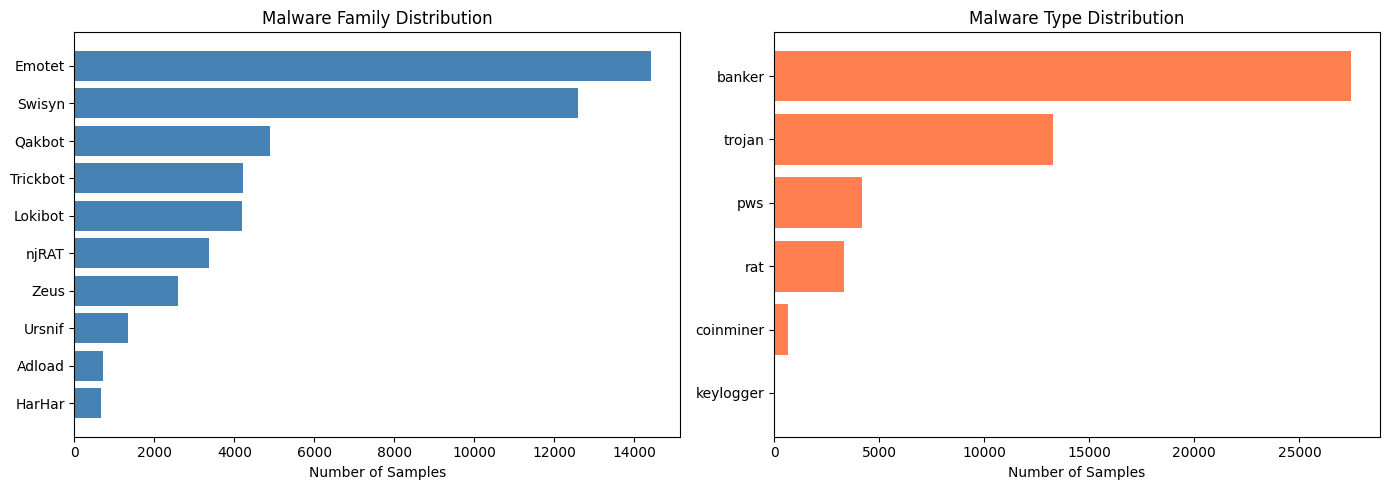

In [64]:
import matplotlib.pyplot as plt

# Visualize malware family distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Family distribution
family_counts = labels_df['classification_family'].value_counts()
axes[0].barh(family_counts.index, family_counts.values, color='steelblue')
axes[0].set_xlabel('Number of Samples')
axes[0].set_title('Malware Family Distribution')
axes[0].invert_yaxis()

# Type distribution
type_counts = labels_df['classification_type'].value_counts()
axes[1].barh(type_counts.index, type_counts.values, color='coral')
axes[1].set_xlabel('Number of Samples')
axes[1].set_title('Malware Type Distribution')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Summary: Key Fields for Signature Generation

### behavior.summary (Dynamic Analysis)
| Field | Use Case |
|-------|----------|
| `mutexes` | Unique mutex patterns for family identification |
| `keys` | All registry access |
| `write_keys` | Registry persistence detection |
| `read_keys` / `delete_keys` | Registry manipulation patterns |
| `executed_commands` | Command-line patterns |
| `write_files` / `read_files` / `delete_files` | File system activity |
| `resolved_apis` | Dynamic API imports (key for behavior signatures) |
| `started_services` / `created_services` | Service manipulation |

### static.pe (Static Analysis)
| Field | Use Case |
|-------|----------|
| `imphash` | Import hash for clustering similar samples |
| `sections` | Detect packing (high entropy) |
| `peid_signatures` | Packer detection |
| `imports` | Suspicious API imports |
| `exports` | DLL identification |

**Note:** Field availability varies across samples. Use the field availability analysis (Step 8) to choose reliable features.

## Conclusion

This exploration revealed the CAPEv2 dataset structure. Key findings:
- **48,976 samples** across 10 malware families and 6 types
- **behavior.summary** contains the most useful pre-extracted features (mutexes, registry keys, resolved_apis, files, commands)
- **static.pe** provides PE analysis data (imports, sections, imphash)
- **Network data** is sparse/missing in most samples

**Next**: See `feature_extraction.ipynb` for the feature extraction pipeline.